In [1]:
import psycopg2
import sys

import pandas as pd
import numpy as np
from matplotlib.pyplot import xticks
import matplotlib.pyplot as plt
plt.rc("font",size=14)
%matplotlib inline

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid",color_codes=True)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

#from scipy.stats import chi2_contingency
#from scipy.stats import chi2
#import math

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
conn = psycopg2.connect(
                host="dwh-production.db.eigensonne.de",
                port="5432",
                database="eigensonne_dwh",
                user="amareid",
                password="ey4cMnS6Chni29G2H2iL",
                sslmode="require")


In [258]:
query = """select *
        from eigensonne_dwh.public.lead_scoring_sample """
cr = conn.cursor()
result = cr.execute(query)
cols = []

for col in cr.description:
    cols.append(col[0])
    
final_list=[]
for val in cr.fetchall():
    final_list.append(dict(zip(cols,val)))
    
cr.close()
base=pd.DataFrame(final_list)
base.head()


,id,lead_source,lead_medium,bundesland,radius_category,distance,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_upload,time_since_last_db_activity,has_reached_wfp
0,00Q5J000003aptVUAQ,Website,display,Thüringen,150,141.0,Rent,1,1,0,11,1
1,00Q5J000003YQV8UAO,KP,affiliate,Nordrhein-Westfalen,75,57.0,Regular,0,0,0,21,0
2,00Q5J000003Zks7UAC,KP,affiliate,Hessen,75,40.0,Regular,0,0,0,0,0
3,00Q5J000003YCMeUAO,KP,affiliate,Berlin,35,5.0,Regular,1,0,0,12,0
4,00Q5J000003Z7SdUAK,Wattfox,affiliate,Nordrhein-Westfalen,35,7.0,Regular,1,0,0,11,0


In [259]:
# DATA PREPARATION

#checking duplicates
sum(base.duplicated(subset = 'id')) == 0
# No duplicate values

True

In [174]:
print(base.shape)
base.dtypes

(18127, 12)


id                              object
lead_source                     object
lead_medium                     object
bundesland                      object
radius_category                 object
distance                       float64
record_type_name_c              object
has_opened                       int64
has_clicked_non_photo_url        int64
photo_upload                     int64
time_since_last_db_activity      int64
has_reached_wfp                  int64
dtype: object

In [175]:
#drop data closest team and radius category cause of duplocates
base=base.drop(['radius_category','distance'],1)

In [176]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18127 entries, 0 to 18126
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           18127 non-null  object
 1   lead_source                  18112 non-null  object
 2   lead_medium                  17044 non-null  object
 3   bundesland                   18033 non-null  object
 4   record_type_name_c           18127 non-null  object
 5   has_opened                   18127 non-null  int64 
 6   has_clicked_non_photo_url    18127 non-null  int64 
 7   photo_upload                 18127 non-null  int64 
 8   time_since_last_db_activity  18127 non-null  int64 
 9   has_reached_wfp              18127 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 1.4+ MB


In [177]:
base.describe()

,has_opened,has_clicked_non_photo_url,photo_upload,time_since_last_db_activity,has_reached_wfp
count,18127.000000,18127.000000,18127.000000,18127.000000,18127.000000
mean,0.700006,0.097534,0.171347,7.815469,0.352623
std,0.458268,0.296692,0.376822,12.097520,0.477800
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,3.000000,0.000000
75%,1.000000,0.000000,0.000000,14.000000,1.000000
max,1.000000,1.000000,1.000000,113.000000,1.000000


In [178]:
base.isnull().sum()

id                                0
lead_source                      15
lead_medium                    1083
bundesland                       94
record_type_name_c                0
has_opened                        0
has_clicked_non_photo_url         0
photo_upload                      0
time_since_last_db_activity       0
has_reached_wfp                   0
dtype: int64

In [179]:
#see percentage of null values to drop the once >= 70%

round(100*(base.isnull().sum()/len(base.index)), 2)

id                             0.00
lead_source                    0.08
lead_medium                    5.97
bundesland                     0.52
record_type_name_c             0.00
has_opened                     0.00
has_clicked_non_photo_url      0.00
photo_upload                   0.00
time_since_last_db_activity    0.00
has_reached_wfp                0.00
dtype: float64

In [180]:
# we will drop the columns having more than 70% NA values.
data = base.drop(base.loc[:,list(round(100*(base.isnull().sum()/len(base.index)), 2)>70)].columns, 1)

In [181]:
# Now we will take care of null values in each column one by one.
data['lead_source'].describe()

count       18112
unique         13
top       Wattfox
freq         6119
Name: lead_source, dtype: object

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text major ticklabel objects>)

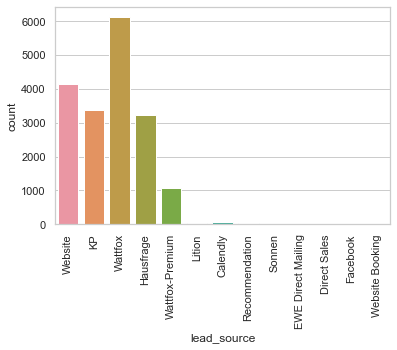

In [182]:
sns.countplot(data['lead_source'])
xticks(rotation = 90)

In [183]:
data.groupby(['lead_source'])['id'].count()

lead_source
Calendly                65
Direct Sales             4
EWE Direct Mailing       3
Facebook                 1
Hausfrage             3224
KP                    3379
Lition                  33
Recommendation          32
Sonnen                  23
Wattfox               6119
Wattfox-Premium       1071
Website               4157
Website Booking          1
Name: id, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

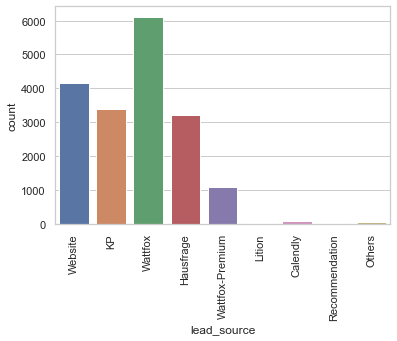

In [184]:
#taking into account that we always knows when leads come from affiliates, we will call the null values and 
#every lead comming from a source with a total of leads < 30 'Other'
data['lead_source'] = data['lead_source'].replace(np.nan, 'Others')
data['lead_source'] = data['lead_source'].replace(data.loc[data.groupby('lead_source').lead_source.transform('count').lt(30),
                               'lead_source'],'Others')

sns.countplot(data['lead_source'])
xticks(rotation = 90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

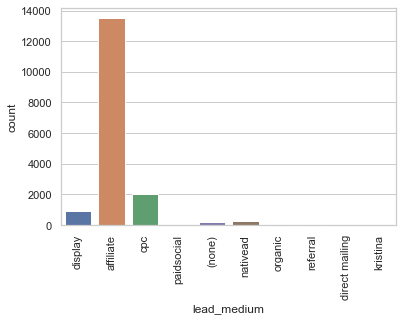

In [185]:
sns.countplot(data['lead_medium'])
xticks(rotation = 90)

In [186]:
data.groupby(['lead_medium'])['id'].count()

lead_medium
(none)              212
affiliate         13513
cpc                2015
direct mailing        3
display             898
kristina              1
nativead            277
organic              80
paidsocial            5
referral             40
Name: id, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

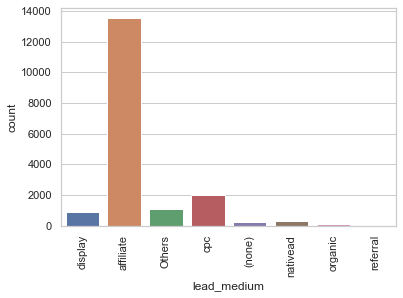

In [187]:
#taking into account that we always know when leads come from affiliates, we will call the null values and 
#every lead comming from a medium with a total of leads < 30 'Others'
data['lead_medium'] = data['lead_medium'].replace(np.nan, 'Others')
data['lead_medium'] = data['lead_medium'].replace(data.loc[data.groupby('lead_medium').lead_medium.transform('count').lt(30),
                               'lead_medium'],'Others')

sns.countplot(data['lead_medium'])
xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

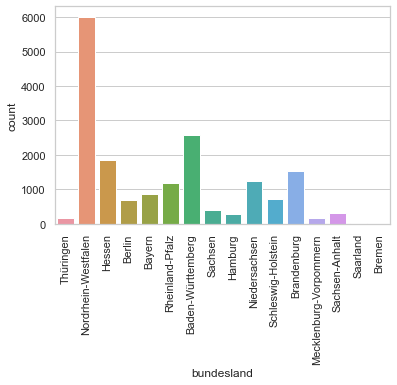

In [188]:
sns.countplot(data['bundesland'])
xticks(rotation = 90)

In [189]:
data.groupby(['bundesland'])['id'].count()

bundesland
Baden-Württemberg         2567
Bayern                     874
Berlin                     677
Brandenburg               1529
Bremen                       6
Hamburg                    274
Hessen                    1866
Mecklenburg-Vorpommern     175
Niedersachsen             1230
Nordrhein-Westfalen       6013
Rheinland-Pfalz           1198
Saarland                    29
Sachsen                    389
Sachsen-Anhalt             325
Schleswig-Holstein         706
Thüringen                  175
Name: id, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

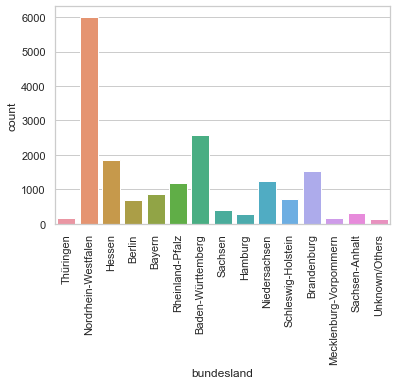

In [190]:
#taking into account that we always know when leads come from affiliates, we will call the null values and 
#every lead comming from a bundesland with a total of leads < 30 'Others'
data['bundesland'] = data['bundesland'].replace(np.nan, 'Unknown/Others')
data['bundesland'] = data['bundesland'].replace(data.loc[data.groupby('bundesland').lead_medium.transform('count').lt(30),
                               'bundesland'],'Unknown/Others')

sns.countplot(data['bundesland'])
xticks(rotation = 90)

In [192]:
#plt1 = sns.boxplot(data['distance'])
#xticks(rotation = 90)

In [194]:
# As we can see there are a number of outliers in the data.
# We will cap the outliers to 95% value for analysis.
#percentiles = data['distance'].quantile([0.00,0.95]).values
#data['distance'][data['distance'] <= percentiles[0]] = percentiles[0]
#data['distance'][data['distance'] >= percentiles[1]] = percentiles[1]
#sns.boxplot(data['distance'])

In [196]:
#data['distance'].median()

In [198]:
#sns.boxplot(y = 'distance', x = 'photo_upload', data = data)
#median for converted and non converted leads is the same

In [199]:
#we will substitute the missing data with the median 
#data['distance'] = data['distance'].replace(np.nan, data['distance'].median())


In [200]:
#sns.countplot(data['radius_category'])
#xticks(rotation = 90)

In [201]:
#data.groupby(['radius_category'])['id'].count()

In [202]:
#as we have substituted distance with the median (which is 37) we will substitude the category with 75
#data['radius_category'] = data['radius_category'].replace(np.nan, '75')


#sns.countplot(data['radius_category'])
#xticks(rotation = 90)

In [203]:
data['record_type_name_c'].describe()


count       18127
unique          2
top       Regular
freq        14130
Name: record_type_name_c, dtype: object

In [204]:
round(100*(data.isnull().sum()/len(data.index)), 2)

id                             0.0
lead_source                    0.0
lead_medium                    0.0
bundesland                     0.0
record_type_name_c             0.0
has_opened                     0.0
has_clicked_non_photo_url      0.0
photo_upload                   0.0
time_since_last_db_activity    0.0
has_reached_wfp                0.0
dtype: float64

In [205]:
#Exploratory Data Analytics
# Univariate Analysis 

In [206]:
Converted = (sum(data['photo_upload'])/len(data['photo_upload'].index))*100
Converted

17.134661002923814

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

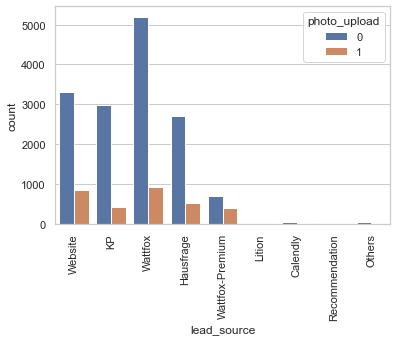

In [207]:
#lead_source 
sns.countplot(x = "lead_source", hue = "photo_upload", data = data)
xticks(rotation = 90)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

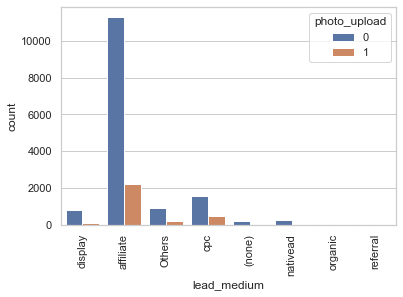

In [208]:
#lead_source 
sns.countplot(x = "lead_medium", hue = "photo_upload", data = data)
xticks(rotation = 90)

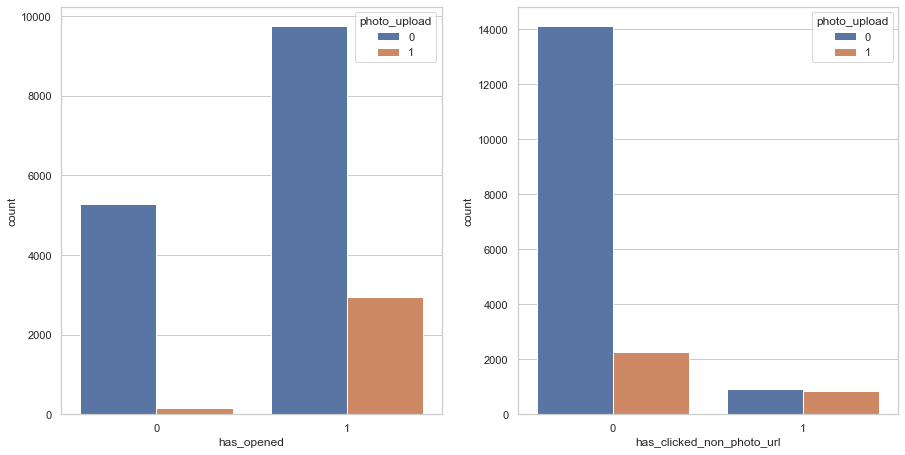

In [209]:
fig, axs = plt.subplots(1,2,figsize = (15,7.5))
sns.countplot(x = "has_opened", hue = "photo_upload", data = data, ax = axs[0])
sns.countplot(x = "has_clicked_non_photo_url", hue = "photo_upload", data = data, ax = axs[1])

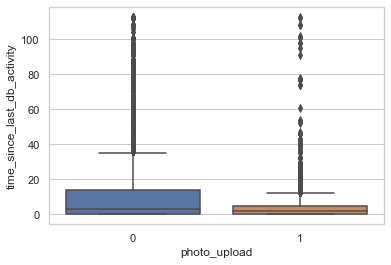

In [210]:
sns.boxplot(y = 'time_since_last_db_activity', x = 'photo_upload', data = data)

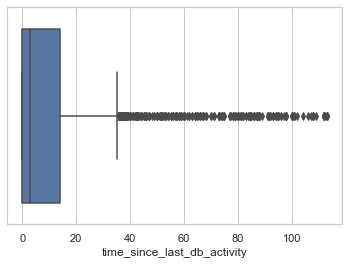

In [211]:
sns.boxplot(data['time_since_last_db_activity'])

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

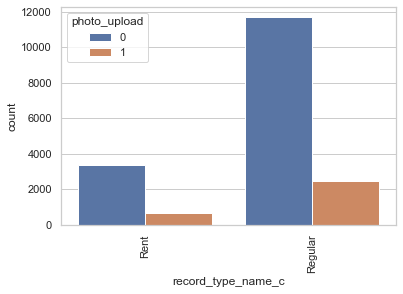

In [212]:
#record_type_name_c 
sns.countplot(x = "record_type_name_c", hue = "photo_upload", data = data)
xticks(rotation = 90)

In [213]:
data.head(10)

,id,lead_source,lead_medium,bundesland,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_upload,time_since_last_db_activity,has_reached_wfp
0,00Q5J000003aptVUAQ,Website,display,Thüringen,Rent,1,1,0,11,1
1,00Q5J000003YQV8UAO,KP,affiliate,Nordrhein-Westfalen,Regular,0,0,0,21,0
2,00Q5J000003Zks7UAC,KP,affiliate,Hessen,Regular,0,0,0,0,0
3,00Q5J000003YCMeUAO,KP,affiliate,Berlin,Regular,1,0,0,12,0
4,00Q5J000003Z7SdUAK,Wattfox,affiliate,Nordrhein-Westfalen,Regular,1,0,0,11,0
5,00Q5J000003YpOpUAK,Wattfox,affiliate,Bayern,Regular,1,0,0,0,0
6,00Q5J000003ZedkUAC,Wattfox,affiliate,Rheinland-Pfalz,Regular,1,0,0,14,1
7,00Q5J000003b0gTUAQ,Website,display,Baden-Württemberg,Rent,1,0,0,3,0
8,00Q5J000003YreOUAS,Website,display,Baden-Württemberg,Rent,0,0,0,3,0
9,00Q5J000003aaRvUAI,Hausfrage,affiliate,Rheinland-Pfalz,Rent,1,0,0,14,1


In [214]:
# Data Preparation



In [215]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.

dummy1 = pd.get_dummies(data[['record_type_name_c','lead_source',# 'radius_category',
                           'lead_medium','bundesland']], drop_first=True)

# first value is dropped because the category variables enter the regression with the logic k-1. 
#For more information see:
#https://stats.stackexchange.com/questions/115049/why-do-we-need-to-dummy-code-categorical-variables


#dummy1 = pd.get_dummies(data[['record_type_name_c','lead_source', 
#                           'lead_medium','bundesland', 'closest_team', 'radius_category']], 
#                        columns=['record_type_name_c','lead_source', 
#                           'lead_medium','bundesland', 'closest_team', 'radius_category'])

dummy1.head()

,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Recommendation,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [216]:
# Adding the results to the master dataframe
data = pd.concat([data, dummy1], axis=1)
data.head()

,id,lead_source,lead_medium,bundesland,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_upload,time_since_last_db_activity,has_reached_wfp,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Recommendation,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
0,00Q5J000003aptVUAQ,Website,display,Thüringen,Rent,1,1,0,11,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,00Q5J000003YQV8UAO,KP,affiliate,Nordrhein-Westfalen,Regular,0,0,0,21,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,00Q5J000003Zks7UAC,KP,affiliate,Hessen,Regular,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,00Q5J000003YCMeUAO,KP,affiliate,Berlin,Regular,1,0,0,12,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,00Q5J000003Z7SdUAK,Wattfox,affiliate,Nordrhein-Westfalen,Regular,1,0,0,11,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [217]:
data = data.drop(['lead_source', 'lead_medium',	'bundesland',#'radius_category',
                             'record_type_name_c'], axis = 1)


In [218]:
data.head(10)

,id,has_opened,has_clicked_non_photo_url,photo_upload,time_since_last_db_activity,has_reached_wfp,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Recommendation,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
0,00Q5J000003aptVUAQ,1,1,0,11,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,00Q5J000003YQV8UAO,0,0,0,21,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,00Q5J000003Zks7UAC,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,00Q5J000003YCMeUAO,1,0,0,12,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,00Q5J000003Z7SdUAK,1,0,0,11,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,00Q5J000003YpOpUAK,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,00Q5J000003ZedkUAC,1,0,0,14,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7,00Q5J000003b0gTUAQ,1,0,0,3,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,00Q5J000003YreOUAS,0,0,0,3,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,00Q5J000003aaRvUAI,1,0,0,14,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [219]:
#train-test split 
# Putting feature variable to X
X = data.drop(['id','photo_upload'], axis=1)
X.head()

,has_opened,has_clicked_non_photo_url,time_since_last_db_activity,has_reached_wfp,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Recommendation,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
0,1,1,11,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,21,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1,0,12,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,11,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [220]:
y = data['photo_upload']

y.head()

0    0
1    0
2    0
3    0
4    0
Name: photo_upload, dtype: int64

In [260]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, test_size=0.30, random_state=None)

In [261]:
#feature scaling
scaler = StandardScaler()

X_train[['time_since_last_db_activity']] = scaler.fit_transform(
    X_train[['time_since_last_db_activity']])

X_train.head()

<ipython-input-261-84b74e90d621>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['time_since_last_db_activity']] = scaler.fit_transform(
/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,has_opened,has_clicked_non_photo_url,time_since_last_db_activity,has_reached_wfp,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Recommendation,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
17055,0,0,4.699486,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6493,0,0,-0.395989,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4665,1,0,-0.560359,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
720,1,0,1.576453,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
13850,1,0,-0.313803,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [262]:
#How many conversions do we have 

Converted = (sum(data['photo_upload'])/len(data['photo_upload'].index))*100
Converted

17.134661002923814

In [263]:
#Model building 

In [264]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           photo_upload   No. Observations:                12688
Model:                            GLM   Df Residuals:                    12653
Model Family:                Binomial   Df Model:                           34
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2756.9
Date:                Fri, 22 Jan 2021   Deviance:                       5513.9
Time:                        11:24:42   Pearson chi2:                 1.28e+11
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -4.6547      0.690     -6.748      0.000      -6.007      -3.303
has_opened                            1.5931      0.121     13.114      0.000       1.355       1.831
has_clicked_non_photo_url             0.9232      0.097      9.517      0.000       0.733       1.113
time_since_last_db_activity          -2.4998      0.080    -31.151      0.000      -2.657      -2.342
has_reached_wfp                       4.7482      0.107     44.451      0.000       4.539       4.958
record_type_name_c_Rent              -0.6414      0.084     -7.599      0.000      -0.807      -0.476
lead_source_Hausfrage                -1.3614      0.734     -1.855      0.064      -2.800       0.077
lead_source_KP                       -1.4217      0.736     -1.931      0.054      -2.865       0.022
lead_source_Lition                   -0.2743      1.060     -0.259      0.796      -2.351       1.802
lead_source_Others                    0.6972      0.922      0.756      0.450      -1.110       2.505
lead_source_Recommendation            1.0146      1.407      0.721      0.471      -1.743       3.772
lead_source_Wattfox                  -1.0163      0.731     -1.390      0.165      -2.450       0.417
lead_source_Wattfox-Premium          -1.3823      0.738     -1.873      0.061      -2.829       0.064
lead_source_Website                  -0.8149      0.595     -1.370      0.171      -1.981       0.351
lead_medium_Others                   -0.1502      0.371     -0.405      0.685      -0.877       0.576
lead_medium_affiliate                -0.5241      0.583     -0.898      0.369      -1.668       0.620
lead_medium_cpc                      -0.3267      0.339     -0.965      0.335      -0.990       0.337
lead_medium_display                  -0.8649      0.374     -2.313      0.021      -1.598      -0.132
lead_medium_nativead                 -0.9949      0.455     -2.189      0.029      -1.886      -0.104
lead_medium_organic                   0.0291      0.600      0.048      0.961      -1.146       1.204
lead_medium_referral                 -1.0917      1.229     -0.888      0.374      -3.501       1.317
bundesland_Bayern                    -0.1640      0.194     -0.846      0.398      -0.544       0.216
bundesland_Berlin                     0.2245      0.184      1.218      0.223      -0.137       0.586
bundesland_Brandenburg               -0.0328      0.142     -0.230      0.818      -0.312       0.246
bundesland_Hamburg                    0.2443      0.302      0.809      0.418      -0.347       0.836
bundesland_Hessen                    -0.2211      0.143     -1.547      0.122      -0.501       0.059
bundesland_Mecklenburg-Vorpommern    -0.5360      0.444     -1.208      0.227      -1.406       0.334
bundesland_Niedersachse

In [265]:
# feature selection using RFE

logreg = LogisticRegression()

rfe = RFE(logreg, 15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
rfe.support_

/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=15 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True, False, False,  True, False,  True,  True,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False,  True])

In [266]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('has_opened', True, 1),
 ('has_clicked_non_photo_url', True, 1),
 ('time_since_last_db_activity', True, 1),
 ('has_reached_wfp', True, 1),
 ('record_type_name_c_Rent', True, 1),
 ('lead_source_Hausfrage', True, 1),
 ('lead_source_KP', True, 1),
 ('lead_source_Lition', False, 6),
 ('lead_source_Others', True, 1),
 ('lead_source_Recommendation', True, 1),
 ('lead_source_Wattfox', False, 3),
 ('lead_source_Wattfox-Premium', True, 1),
 ('lead_source_Website', False, 2),
 ('lead_medium_Others', False, 18),
 ('lead_medium_affiliate', True, 1),
 ('lead_medium_cpc', False, 10),
 ('lead_medium_display', True, 1),
 ('lead_medium_nativead', True, 1),
 ('lead_medium_organic', False, 8),
 ('lead_medium_referral', False, 15),
 ('bundesland_Bayern', False, 12),
 ('bundesland_Berlin', False, 4),
 ('bundesland_Brandenburg', False, 19),
 ('bundesland_Hamburg', False, 5),
 ('bundesland_Hessen', False, 11),
 ('bundesland_Mecklenburg-Vorpommern', True, 1),
 ('bundesland_Niedersachsen', False, 20),
 ('bun

In [267]:
col = X_train.columns[rfe.support_]
col

Index(['has_opened', 'has_clicked_non_photo_url',
       'time_since_last_db_activity', 'has_reached_wfp',
       'record_type_name_c_Rent', 'lead_source_Hausfrage', 'lead_source_KP',
       'lead_source_Others', 'lead_source_Recommendation',
       'lead_source_Wattfox-Premium', 'lead_medium_affiliate',
       'lead_medium_display', 'lead_medium_nativead',
       'bundesland_Mecklenburg-Vorpommern', 'bundesland_Unknown/Others'],
      dtype='object')

In [268]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           photo_upload   No. Observations:                12688
Model:                            GLM   Df Residuals:                    12672
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2765.6
Date:                Fri, 22 Jan 2021   Deviance:                       5531.3
Time:                        11:25:02   Pearson chi2:                 1.07e+11
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -5.7623      0.155    -37.126      0.000      -6.066      -5.458
has_opened                            1.5887      0.121     13.174      0.000       1.352       1.825
has_clicked_non_photo_url             0.9229      0.097      9.537      0.000       0.733       1.113
time_since_last_db_activity          -2.4939      0.080    -31.215      0.000      -2.650      -2.337
has_reached_wfp                       4.7386      0.106     44.671      0.000       4.531       4.946
record_type_name_c_Rent              -0.6490      0.084     -7.724      0.000      -0.814      -0.484
lead_source_Hausfrage                -0.3493      0.103     -3.400      0.001      -0.551      -0.148
lead_source_KP                       -0.3957      0.111     -3.567      0.000      -0.613      -0.178
lead_source_Others                    1.6344      0.676      2.416      0.016       0.309       2.960
lead_source_Recommendation            1.1340      0.843      1.345      0.178      -0.518       2.786
lead_source_Wattfox-Premium          -0.3783      0.114     -3.332      0.001      -0.601      -0.156
lead_medium_affiliate                -0.4874      0.105     -4.650      0.000      -0.693      -0.282
lead_medium_display                  -0.6137      0.206     -2.985      0.003      -1.017      -0.211
lead_medium_nativead                 -0.7374      0.330     -2.238      0.025      -1.383      -0.092
bundesland_Mecklenburg-Vorpommern    -0.4636      0.436     -1.063      0.288      -1.318       0.391
bundesland_Unknown/Others             0.7679      0.506      1.517      0.129      -0.224       1.760
=====================================================================================================
"""

In [269]:
col2 = col.drop(['bundesland_Unknown/Others',
                  'bundesland_Mecklenburg-Vorpommern','lead_source_Recommendation'],1)
X_train_sm = sm.add_constant(X_train[col2])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           photo_upload   No. Observations:                12688
Model:                            GLM   Df Residuals:                    12675
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2768.3
Date:                Fri, 22 Jan 2021   Deviance:                       5536.7
Time:                        11:26:45   Pearson chi2:                 1.99e+11
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -5.7469      0.155    -37.194      0.000      -6.050      -5.444
has_opened                      1.5856      0.120     13.169      0.000       1.350       1.822
has_clicked_non_photo_url       0.9218      0.097      9.534      0.000       0.732       1.111
time_since_last_db_activity    -2.4927      0.080    -31.231      0.000      -2.649      -2.336
has_reached_wfp                 4.7404      0.106     44.719      0.000       4.533       4.948
record_type_name_c_Rent        -0.6523      0.084     -7.770      0.000      -0.817      -0.488
lead_source_Hausfrage          -0.3436      0.102     -3.356      0.001      -0.544      -0.143
lead_source_KP                 -0.3969      0.111     -3.580      0.000      -0.614      -0.180
lead_source_Others              1.7556      0.666      2.636      0.008       0.450       3.061
lead_source_Wattfox-Premium    -0.3813      0.114     -3.360      0.001      -0.604      -0.159
lead_medium_affiliate          -0.5009      0.104     -4.803      0.000      -0.705      -0.296
lead_medium_display            -0.6323      0.205     -3.083      0.002      -1.034      -0.230
lead_medium_nativead           -0.7534      0.329     -2.288      0.022      -1.399      -0.108
===============================================================================================
"""

In [270]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

17055    2.610500e-08
6493     3.478376e-03
4665     5.927146e-02
720      1.247980e-04
13850    4.661592e-01
8552     8.985017e-01
2020     3.346249e-01
7971     7.606763e-01
5622     1.449917e-01
2609     6.412148e-03
dtype: float64

In [271]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([2.61050023e-08, 3.47837578e-03, 5.92714601e-02, 1.24797969e-04,
       4.66159207e-01, 8.98501659e-01, 3.34624933e-01, 7.60676296e-01,
       1.44991652e-01, 6.41214756e-03])

In [272]:
#
y_train_pred_final = pd.DataFrame({'photo_upload':y_train.values, 'photo_upload_prob':y_train_pred})
y_train_pred_final['id'] = y_train.index
y_train_pred_final.head()

,photo_upload,photo_upload_prob,id
0,0,2.610500e-08,17055
1,0,3.478376e-03,6493
2,1,5.927146e-02,4665
3,0,1.247980e-04,720
4,0,4.661592e-01,13850


In [273]:
#Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

y_train_pred_final['predicted'] = y_train_pred_final.photo_upload_prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,photo_upload,photo_upload_prob,id,predicted
0,0,2.610500e-08,17055,0
1,0,3.478376e-03,6493,0
2,1,5.927146e-02,4665,0
3,0,1.247980e-04,720,0
4,0,4.661592e-01,13850,0


In [274]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.photo_upload, y_train_pred_final.predicted )
print(confusion)


[[10150   366]
 [  508  1664]]


In [275]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.photo_upload, y_train_pred_final.predicted))

0.9311160151324086


In [276]:
# Check for the VIF values of the feature variables. 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col2].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col2].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

# when VIF >5 then multicollinearity in our data is not severe enough to warrant corrective meassures
# to remove structural multicollinearity -> https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

,Features,VIF
10,lead_medium_display,3.89
0,has_opened,2.95
3,has_reached_wfp,1.96
6,lead_source_KP,1.63
5,lead_source_Hausfrage,1.56
4,record_type_name_c_Rent,1.46
9,lead_medium_affiliate,1.32
1,has_clicked_non_photo_url,1.23
11,lead_medium_nativead,1.19
7,lead_source_Others,1.10


In [277]:
# metrics beyond simply accuracy
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [278]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7661141804788214

In [279]:
# Let us calculate specificity
TN / float(TN+FP)

0.9651958919741347

In [280]:
# positive predictive value 
print (TP / float(TP+FP))

0.819704433497537


In [281]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9523362732219929


In [282]:
#An ROC curve demonstrates several things:

#It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be 
#accompanied by a decrease in specificity).
#The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
#The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

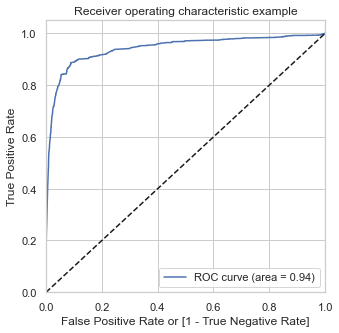

In [283]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.photo_upload, 
                                         y_train_pred_final.photo_upload_prob, drop_intermediate = False )
draw_roc(y_train_pred_final.photo_upload, y_train_pred_final.photo_upload_prob)

In [284]:
# Optimal cutoff probability is that prob where we get balanced sensitivity and specificity
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.photo_upload_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,photo_upload,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,2.610500e-08,17055,0,1,0,0,0,0,0,0,0,0,0
1,0,3.478376e-03,6493,0,1,0,0,0,0,0,0,0,0,0
2,1,5.927146e-02,4665,0,1,0,0,0,0,0,0,0,0,0
3,0,1.247980e-04,720,0,1,0,0,0,0,0,0,0,0,0
4,0,4.661592e-01,13850,0,1,1,1,1,1,0,0,0,0,0


In [285]:

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.photo_upload, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.171185  1.000000  0.000000
0.1   0.1  0.836854  0.911602  0.821415
0.2   0.2  0.890054  0.896869  0.888646
0.3   0.3  0.913383  0.864641  0.923450
0.4   0.4  0.927491  0.818140  0.950076
0.5   0.5  0.931116  0.766114  0.965196
0.6   0.6  0.927333  0.682781  0.977843
0.7   0.7  0.915274  0.563996  0.987828
0.8   0.8  0.885325  0.350829  0.995721
0.9   0.9  0.848755  0.117864  0.999715


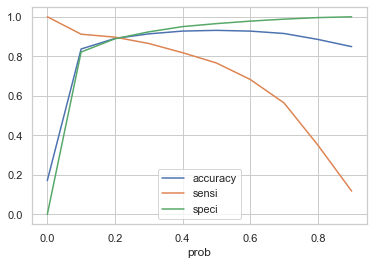

In [286]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [287]:
#### From the curve above, 0.1 is the optimum point to take it as a cutoff probability.

y_train_pred_final['final_predicted'] = y_train_pred_final.photo_upload_prob.map( lambda x: 1 if x > 0.2 else 0)

y_train_pred_final.head()

,photo_upload,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,2.610500e-08,17055,0,1,0,0,0,0,0,0,0,0,0,0
1,0,3.478376e-03,6493,0,1,0,0,0,0,0,0,0,0,0,0
2,1,5.927146e-02,4665,0,1,0,0,0,0,0,0,0,0,0,0
3,0,1.247980e-04,720,0,1,0,0,0,0,0,0,0,0,0,0
4,0,4.661592e-01,13850,0,1,1,1,1,1,0,0,0,0,0,1


In [288]:
y_train_pred_final['Lead_Score'] = y_train_pred_final.photo_upload_prob.map( lambda x: round(x*100))

y_train_pred_final.head()

,photo_upload,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted,Lead_Score
0,0,2.610500e-08,17055,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,3.478376e-03,6493,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1,5.927146e-02,4665,0,1,0,0,0,0,0,0,0,0,0,0,6
3,0,1.247980e-04,720,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,4.661592e-01,13850,0,1,1,1,1,1,0,0,0,0,0,1,47


In [289]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.photo_upload, y_train_pred_final.final_predicted)

confusion2 = metrics.confusion_matrix(y_train_pred_final.photo_upload, y_train_pred_final.final_predicted )
confusion2

TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8968692449355433

In [290]:
# Let us calculate specificity
TN / float(TN+FP)

0.8886458729554964

In [291]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.11135412704450362


In [292]:
# Positive predictive value 
print (TP / float(TP+FP))

0.6245591535748637


In [293]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9765910753474762


In [294]:
# Precision and recall

#Looking at the confusion matrix again

confusion = metrics.confusion_matrix(y_train_pred_final.photo_upload, y_train_pred_final.predicted )
confusion

array([[10150,   366],
       [  508,  1664]])

In [295]:
##### Precision
TP / TP + FP

confusion[1,1]/(confusion[0,1]+confusion[1,1])

0.819704433497537

In [296]:
##### Recall
TP / TP + FN

confusion[1,1]/(confusion[1,0]+confusion[1,1])

0.7661141804788214

In [297]:
y_train_pred_final.photo_upload, y_train_pred_final.predicted

(0        0
 1        0
 2        1
 3        0
 4        0
         ..
 12683    0
 12684    0
 12685    0
 12686    0
 12687    0
 Name: photo_upload, Length: 12688, dtype: int64,
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 12683    0
 12684    0
 12685    0
 12686    0
 12687    0
 Name: predicted, Length: 12688, dtype: int64)

In [298]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.photo_upload, y_train_pred_final.photo_upload_prob)

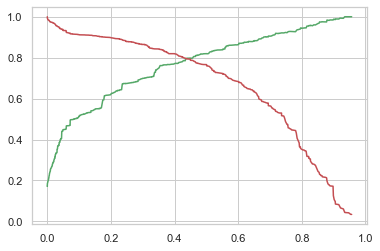

In [299]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [301]:
#Making predictions on the test set

X_test[['time_since_last_db_activity']] = scaler.fit_transform(X_test[['time_since_last_db_activity']])

X_train.head()

<ipython-input-301-c944f2535866>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[['time_since_last_db_activity']] = scaler.fit_transform(X_test[['time_since_last_db_activity']])
/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,has_opened,has_clicked_non_photo_url,time_since_last_db_activity,has_reached_wfp,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Recommendation,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
17055,0,0,4.699486,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6493,0,0,-0.395989,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4665,1,0,-0.560359,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
720,1,0,1.576453,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
13850,1,0,-0.313803,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [302]:
X_test = X_test[col2]
X_test.head()

,has_opened,has_clicked_non_photo_url,time_since_last_db_activity,has_reached_wfp,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Others,lead_source_Wattfox-Premium,lead_medium_affiliate,lead_medium_display,lead_medium_nativead
10264,1,1,-0.654502,1,0,0,0,0,0,1,0,0
1631,1,1,0.518895,1,0,0,0,0,0,0,0,0
6518,1,0,0.686524,0,0,0,0,0,0,1,0,0
5630,1,1,-0.235431,1,0,1,0,0,0,1,0,0
14542,1,0,0.770338,1,0,0,0,0,0,1,0,0


In [303]:
X_test_sm = sm.add_constant(X_test)

In [304]:
#maiking predictions on the test set
y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]


10264    0.932856
1631     0.551679
6518     0.001703
5630     0.776118
14542    0.136808
4565     0.522539
16327    0.060723
10854    0.209647
6551     0.033211
11366    0.000007
dtype: float64

In [305]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)
# Let's see the head
y_pred_1.head()

,0
10264,0.932856
1631,0.551679
6518,0.001703
5630,0.776118
14542,0.136808


In [306]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
# Putting CustID to index
y_test_df['id'] = y_test_df.index

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

y_pred_final.head()

,photo_upload,id,0
0,1,10264,0.932856
1,0,1631,0.551679
2,0,6518,0.001703
3,1,5630,0.776118
4,0,14542,0.136808


In [307]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'photo_upload_prob'})

# Rearranging the columns
#y_pred_final = y_pred_final.reindex_axis(['id','photo_upload','photo_upload_prob'], axis=1)

# Let's see the head of y_pred_final
y_pred_final.head()

,photo_upload,id,photo_upload_prob
0,1,10264,0.932856
1,0,1631,0.551679
2,0,6518,0.001703
3,1,5630,0.776118
4,0,14542,0.136808


In [308]:
y_pred_final['final_predicted'] = y_pred_final.photo_upload_prob.map(lambda x: 1 if x > 0.2 else 0)
y_pred_final.head()

,photo_upload,id,photo_upload_prob,final_predicted
0,1,10264,0.932856,1
1,0,1631,0.551679,1
2,0,6518,0.001703,0
3,1,5630,0.776118,1
4,0,14542,0.136808,0


In [309]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.photo_upload, y_pred_final.final_predicted)

0.8836183121897407

In [310]:
confusion2 = metrics.confusion_matrix(y_pred_final.photo_upload, y_pred_final.final_predicted )
confusion2

array([[3976,  529],
       [ 104,  830]])

In [311]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [312]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8886509635974305

In [313]:
# Let us calculate specificity
TN / float(TN+FP)

0.8825749167591564

In [319]:
y_pred_final['Lead_Score'] = y_pred_final.photo_upload_prob.map( lambda x: round(x*100))

In [320]:
print(y_pred_final.shape)
y_pred_final.head()

(5439, 5)


,photo_upload,id,photo_upload_prob,final_predicted,Lead_Score
0,1,10264,0.932856,1,93
1,0,1631,0.551679,1,55
2,0,6518,0.001703,0,0
3,1,5630,0.776118,1,78
4,0,14542,0.136808,0,14


In [327]:
y_train_pred_final=y_train_pred_final.drop(['predicted',0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],1)
print(y_train_pred_final.shape)
y_train_pred_final.head()

(12688, 5)


,photo_upload,photo_upload_prob,id,final_predicted,Lead_Score
0,0,2.610500e-08,17055,0,0
1,0,3.478376e-03,6493,0,0
2,1,5.927146e-02,4665,0,6
3,0,1.247980e-04,720,0,0
4,0,4.661592e-01,13850,1,47


In [328]:
y_pred_final=y_pred_final[['id','photo_upload','photo_upload_prob','final_predicted','Lead_Score']]
y_train_pred_final=y_train_pred_final[['id','photo_upload','photo_upload_prob','final_predicted','Lead_Score']]

In [329]:
y_pred_final.head()

,id,photo_upload,photo_upload_prob,final_predicted,Lead_Score
0,10264,1,0.932856,1,93
1,1631,0,0.551679,1,55
2,6518,0,0.001703,0,0
3,5630,1,0.776118,1,78
4,14542,0,0.136808,0,14


In [332]:
pred_values=pd.concat([y_train_pred_final,y_pred_final]).reset_index(drop=True)
pred_values.shape

(18127, 5)

In [333]:
pred_values.head()

,id,photo_upload,photo_upload_prob,final_predicted,Lead_Score
0,17055,0,2.610500e-08,0,0
1,6493,0,3.478376e-03,0,0
2,4665,1,5.927146e-02,0,6
3,720,0,1.247980e-04,0,0
4,13850,0,4.661592e-01,1,47


In [347]:
Final= base.merge(pred_values, how='left',left_index=True,right_on='id', suffixes=('_left', '_right')).reset_index(drop=True)
Final.shape

(18127, 18)

In [348]:
Final.loc[Final.photo_upload_left != Final.photo_upload_right]

,id,id_left,lead_source,lead_medium,bundesland,radius_category,distance,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_upload_left,time_since_last_db_activity,has_reached_wfp,id_right,photo_upload_right,photo_upload_prob,final_predicted,Lead_Score


In [349]:
Final=Final[['id_left','Lead_Score','photo_upload_left','lead_source','lead_medium','bundesland','radius_category','distance',
             'record_type_name_c','has_opened',	'has_clicked_non_photo_url',
             'time_since_last_db_activity',	'has_reached_wfp']]
Final.head(10)

,id_left,Lead_Score,photo_upload_left,lead_source,lead_medium,bundesland,radius_category,distance,record_type_name_c,has_opened,has_clicked_non_photo_url,time_since_last_db_activity,has_reached_wfp
0,00Q5J000003aptVUAQ,39,0,Website,display,Thüringen,150,141.0,Rent,1,1,11,1
1,00Q5J000003YQV8UAO,0,0,KP,affiliate,Nordrhein-Westfalen,75,57.0,Regular,0,0,21,0
2,00Q5J000003Zks7UAC,1,0,KP,affiliate,Hessen,75,40.0,Regular,0,0,0,0
3,00Q5J000003YCMeUAO,0,0,KP,affiliate,Berlin,35,5.0,Regular,1,0,12,0
4,00Q5J000003Z7SdUAK,0,0,Wattfox,affiliate,Nordrhein-Westfalen,35,7.0,Regular,1,0,11,0
5,00Q5J000003YpOpUAK,4,0,Wattfox,affiliate,Bayern,35,14.0,Regular,1,0,0,0
6,00Q5J000003ZedkUAC,23,0,Wattfox,affiliate,Rheinland-Pfalz,75,69.0,Regular,1,0,14,1
7,00Q5J000003b0gTUAQ,1,0,Website,display,Baden-Württemberg,35,22.0,Rent,1,0,3,0
8,00Q5J000003YreOUAS,0,0,Website,display,Baden-Württemberg,35,16.0,Rent,0,0,3,0
9,00Q5J000003aaRvUAI,10,0,Hausfrage,affiliate,Rheinland-Pfalz,75,71.0,Rent,1,0,14,1
